In [1]:
!pip install catboost matplotlib seaborn scikit-learn tqdm numpy pandas vtk

## IMPORTS

In [3]:
import os
import vtk
import glob
import random
from copy import deepcopy
from typing import Dict, List, Optional, Tuple
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from catboost import CatBoostRegressor

In [16]:
PATH_TO_VTK = Path("./vtk_files/")
PATH_TO_CSV = Path("./csv_files/")

CSV_FILES = glob.glob(f"{PATH_TO_CSV}/output*.csv")
VTK_FILES = glob.glob(f"{PATH_TO_VTK}/output*.vtk")

SPLITTER = "/"

In [5]:
# # Leave full files

# FILES_LENGTH = {}

# for file in CSV_FILES:
#     with open(file, "r") as obj:
#         lines = len(obj.readlines())
#     FILES_LENGTH[file.split(".")[-2].split(SPLITTER)[1]] = lines
    
# CSV_FILES = [
#     f"{PATH_TO_CSV}{SPLITTER}{file}.csv" 
#     for file, lines in FILES_LENGTH.items() if lines == 401
# ]
# VTK_FILES = [
#     f"{PATH_TO_VTK}{SPLITTER}{file}.vtk" 
#     for file, lines in FILES_LENGTH.items() if lines == 401
# ]

In [8]:
best_wells_df = pd.read_csv("full.csv", index_col=0)
best_wells_df.head()

,filename,i1,j1
0,output0_0_0,18,13
1,output0_0_1,16,10
2,output0_10_0,11,15
3,output0_10_1,10,18
4,output0_11_0,12,16


In [19]:
VTK_FILES = [
    file for file in VTK_FILES 
    if file.split("/")[1].split(".")[0] in best_wells_df["filename"].values
]

## 1.1. Some Utils

In [21]:
def find_max_prod(file_path: str) -> Dict:
    df = pd.read_csv(file_path)
    max_prod = df["prod"].max()
    max_prod_index = df["prod"].idxmax()
    return {
        "filename": file_path.split(SPLITTER)[1].split(".")[0],
        "i0": df["i0"][max_prod_index],
        "j0": df["j0"][max_prod_index],
        "i1": df["i1"][max_prod_index],
        "j1": df["j1"][max_prod_index],
        "max_prod": max_prod,
    }

In [22]:
def _draw_map_with_wells(
    df: pd.DataFrame, 
    well_df: pd.DataFrame,
    save: bool = False
) -> None:
    plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
    plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False
    
    map_file = df["filename"].iloc[[0]].values[0]
    map_poro = df["poro"].values.reshape((20, 20))
    map_perm = df["perm"].values.reshape((20, 20))

    fig, axs = plt.subplots(1, 2, figsize=[10,4])
    
    try:
        max_prod = df["max_prod"].values[0]
    except KeyError:
        fig.suptitle(f"The best oil production ({map_file})", fontsize=15)
    else:
        fig.suptitle(f"The best oil production = {max_prod:.3f} ({map_file})", fontsize=15)

    img1 = sns.heatmap(
        map_poro, ax=axs[0], square=True, 
        cbar_kws=dict(location="left", shrink=0.8), 
        cmap="Blues", alpha=0.7, linewidths=0.1, linecolor="grey"
    )
    img2 = sns.heatmap(
        map_perm, ax=axs[1], square=True, 
        cbar_kws=dict(location="left", shrink=0.8), 
        cmap="Blues", alpha=0.7, linewidths=0.1, linecolor="grey"
    )
    
    for img in [img1, img2]:
        for _, spine in img.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_alpha(0.3)
        
    axs[0].set_title("PORO")
    axs[1].set_title("PERM")

    coord_x = well_df["x_coord"].values
    coord_y = well_df["y_coord"].values
    well_type = well_df["well_type"].values

    for ax in range(len(axs)): 
        axs[ax].scatter(
            coord_x + 0.5, 
            coord_y + 0.5,
            c="red", 
            s=100, 
            marker='2'
        ) 
        
        for i in range(len(coord_x)):
            axs[ax].text(
                coord_x[i] + 1, 
                coord_y[i] + 2, 
                f"{well_type[i]}", 
                color='red', 
                va='center', 
                ha='center',
                fontsize=10
            )
    
    plt.show()
    
    if save:
        plt.savefig(f"map_{map_file}_with_walls.png")

In [23]:
def draw_map(df: pd.DataFrame, filename: Optional[str] = None) -> None:

    if filename is None:
        filename = random.choice(df["filename"].values)
        
    sub_df = df.query("filename == @filename")
        
    info = sub_df.iloc[0, :]
    
    wells_df = pd.DataFrame({
        "well_type": ['inj_well', 'prod_well'],
        "x_coord": [info['i0'], info['i1']],
        "y_coord": [info['j0'], info['j1']],
    })
    _draw_map_with_wells(sub_df, wells_df)

In [24]:
def load_max_prod() -> pd.DataFrame:
    
    df_max_prod = {}
    for i, filename in enumerate(tqdm(CSV_FILES)):
        df_max_prod[i] = find_max_prod(filename)

    df_max_prod = pd.DataFrame(df_max_prod).T 
    
    return df_max_prod

In [25]:
def load_all_prod() -> pd.DataFrame:
    
    df_all_prod = []
    for i, filename in enumerate(tqdm(CSV_FILES)):
        sub_df = pd.read_csv(filename)
        sub_df["filename"] = [
            name.split("/")[-1].split(".")[0] 
            for name in sub_df["path"].values
        ]
        df_all_prod.append(
            sub_df[["i0", "j0", "i1", "j1", "prod", "filename"]]
        )

    df_all_prod = pd.concat(df_all_prod)
    df_all_prod["GLOBAL_ID"] = list(range(0,400)) * len(CSV_FILES)
    return df_all_prod

In [26]:
def load_geo() -> pd.DataFrame:
    df = []

    for file_path in tqdm(VTK_FILES):
        reader = vtk.vtkDataSetReader()
        reader.SetFileName(file_path)
        reader.ReadAllScalarsOn()
        reader.Update()
        data = reader.GetOutput()  # This contains all data from the VTK
        cell_data = data.GetCellData()  # This contains just the cells data
        scalar_data1 = cell_data.GetArray('PORO')
        scalar_data2 = cell_data.GetArray('PERM')

        sub_df = pd.DataFrame({
            "poro": [np.nan],
            "perm": [np.nan],
            "file": [file_path.split(SPLITTER)[1].split(".")[0]],
        })
        try:
            scalar1 = np.array([scalar_data1.GetValue(i) for i in range(0, data.GetNumberOfCells())])
            scalar2 = np.array([scalar_data2.GetValue(i) for i in range(0, scalar_data2.GetDataSize(), 6)])
            sub_df = pd.DataFrame({
                "poro": scalar1,
                "perm": scalar2,
                "filename": file_path.split(SPLITTER)[1].split(".")[0],
            })
        except AttributeError:
            continue
        except ValueError:
            continue

        df.append(sub_df)

    df = pd.concat(df)
    df["GLOBAL_ID"] = list(range(0,400)) * len(VTK_FILES)

    return df

In [27]:
def plot_mean_abs_error(
    y_true: np.ndarray, y_pred: np.ndarray
) -> None:
    
    error = np.abs(y_true - y_pred)
    mean_error = MAE(y_test, model.predict(X_test))
    
    fig, ax = plt.subplots()
    ax.hist(error, bins=50)
    ax.set_xlabel('Absolute Error')
    ax.set_ylabel('Frequency')
    ax.set_title('Mean Absolute Error: {:.2f}'.format(mean_error))
    
    plt.show()

In [28]:
def draw_difference(
    test_df: pd.DataFrame, 
    test_files: List[str],
    file: Optional[str] = None
) -> None:

    fig, axs = plt.subplots(1, 3, figsize=[20,5])
    plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
    plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False
    
    if file is None:
        file = random.choice(test_files)

    plt.suptitle(file, fontsize=18)
    sub_df = test_df.query(f"index == '{file}'")

    _prod = sub_df["prod"].values.reshape((20,20))
    _pred = sub_df["pred"].values.reshape((20,20))
    _diff = abs(_prod - _pred)

    sns.heatmap(
        _prod, ax=axs[0], square=True, cmap="rocket_r", cbar_kws=dict(location="left", shrink=1.0),
    )

    sns.heatmap(
        _pred, ax=axs[1], square=True, cmap="rocket_r", cbar_kws=dict(location="left", shrink=1.0),
    )

    sns.heatmap(
        _diff, ax=axs[2], square=True, cmap="viridis_r", cbar_kws=dict(location="left", shrink=1.0),
    )

    # Add wells
    prod_max, pred_max = sub_df["prod"].max(), sub_df["pred"].max()

    _fill_wells_prod = test_df[test_df["prod"] == prod_max]
    i11, j11 = _fill_wells_prod["i1"].values[0], _fill_wells_prod["j1"].values[0]
    rect_inj_1 = patches.Rectangle((1, 1), 1, 1, facecolor='blue', alpha=0.5)
    rect_prod_1 = patches.Rectangle((i11, j11), 1, 1, facecolor='blue', alpha=0.5)
    axs[0].add_patch(rect_inj_1)
    axs[0].add_patch(rect_prod_1)
    axs[0].set_title(f"prod, (i1={i11}, j1={j11})", fontsize=20)

    _fill_wells_pred = test_df[test_df["pred"] == pred_max]
    i21, j21 = _fill_wells_pred["i1"].values[0], _fill_wells_pred["j1"].values[0]
    rect_inj_2 = patches.Rectangle((1, 1), 1, 1, facecolor='blue', alpha=0.5)
    rect_prod_2 = patches.Rectangle((i21, j21), 1, 1, facecolor='blue', alpha=0.5)
    axs[1].add_patch(rect_inj_2)
    axs[1].add_patch(rect_prod_2)
    axs[1].set_title(f"pred, (i1={i21}, j1={j21})", fontsize=20)

    axs[2].set_title(f"diff = {abs(prod_max-pred_max):.3f}", fontsize=20)
    rect_prod = patches.Rectangle((i11, j11), 1, 1, facecolor='blue')
    rect_pred = patches.Rectangle((i21, j21), 1, 1, facecolor='blue')
    axs[2].add_patch(rect_prod)
    axs[2].add_patch(rect_pred)

    plt.show()

## 1.2. Merge all data

In [36]:
df_geo = load_geo()
# df_max_prod = load_max_prod()
# df_all_prod = load_all_prod()
# data_max_prod = df_max_prod.merge(
#     df_geo, on=["filename"]
# ).drop("GLOBAL_ID", axis=1)
# data_all_prod = df_all_prod.merge(
#     df_geo, on=["filename", "GLOBAL_ID"]
# ).drop("GLOBAL_ID", axis=1)

data_max_prod = best_wells_df.merge(
    df_geo, on=["filename"]
).drop("GLOBAL_ID", axis=1)
data_max_prod["i0"] = data_max_prod["j0"] = 1

100%|██████████████████████████████████████| 7482/7482 [00:16<00:00, 444.00it/s]


In [37]:
"""
The main DataFrame which includes porosity & permeability for each cell 
in the map and the best well's information (i1, j1, max_prod) for this map.
"""

data_max_prod.head()

,filename,i1,j1,poro,perm,i0,j0
0,output0_0_0,18,13,0.184778,18.2808,1,1
1,output0_0_0,18,13,0.191699,28.5927,1,1
2,output0_0_0,18,13,0.159089,23.8922,1,1
3,output0_0_0,18,13,0.151273,30.6373,1,1
4,output0_0_0,18,13,0.123168,10.7137,1,1


In [38]:
# """
# The main DataFrame which includes 
# porosity & permeability & production for each cell in the map if well was there.
# """

# data_all_prod.head()

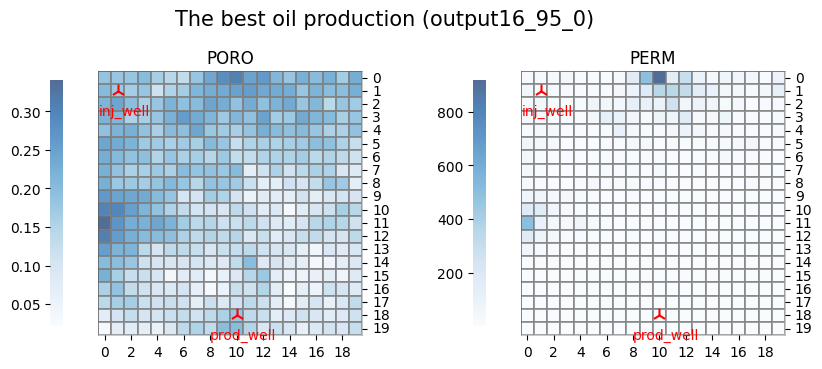

In [39]:
draw_map(data_max_prod)

## 2. The BaseLine Model: СatBoost Regressor

Let's use CatBoost at data_all_prod DataFrame. \
We'll try to forecast all 400 values of the oil production and than will choose the best cell as a result.

The main metric - MAE between real and predicted oil production.

In [17]:
df_for_boost = data_all_prod[
    [
        "filename", "i1", "j1", 
        "poro", 
        "perm", 
        "prod"
    ]
].set_index("filename")

test_files = list(df_for_boost.index.unique()[:5])
val_files = list(df_for_boost.index.unique()[5:15])
train_files = list(df_for_boost.index.unique()[15:])

test_df = df_for_boost[df_for_boost.index.isin(test_files)]
test_df_max_prod = df_max_prod.query("filename in @test_df.index")

val_df = df_for_boost[df_for_boost.index.isin(val_files)]
val_df_max_prod = df_max_prod.query("filename in @val_df.index")


df_for_boost = df_for_boost[df_for_boost.index.isin(train_files)]
df_for_boost.head()

,i1,j1,poro,perm,prod
filename,,,,,
output15_110_0,0,0,0.211493,14.67970,104.208994
output15_110_0,0,1,0.222306,13.05990,108.011757
output15_110_0,0,2,0.161313,3.82167,179.787297
output15_110_0,0,3,0.124355,2.67513,218.693265
output15_110_0,0,4,0.118131,1.69683,240.157197


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df_for_boost.drop("prod", axis=1), 
    df_for_boost["prod"], 
    test_size=0.2,
    random_state=42
)

### 2.1. Consider i1, j1 as a categorical variables

In [19]:
model = CatBoostRegressor(cat_features=["i1", "j1"], loss_function="MAE")
model.fit(X_train, y_train)
test_df["pred"] = model.predict(test_df.drop("prod", axis=1))

0:	learn: 217.0041020	total: 61ms	remaining: 1m
1:	learn: 213.7129468	total: 72.8ms	remaining: 36.3s
2:	learn: 210.4438302	total: 82.1ms	remaining: 27.3s
3:	learn: 207.3001781	total: 90.7ms	remaining: 22.6s
4:	learn: 204.2914104	total: 99ms	remaining: 19.7s
5:	learn: 201.5432551	total: 107ms	remaining: 17.7s
6:	learn: 198.9483214	total: 114ms	remaining: 16.2s
7:	learn: 196.3864776	total: 122ms	remaining: 15.1s
8:	learn: 193.9423179	total: 129ms	remaining: 14.2s
9:	learn: 191.6381411	total: 137ms	remaining: 13.5s
10:	learn: 189.4815470	total: 144ms	remaining: 12.9s
11:	learn: 187.3126804	total: 151ms	remaining: 12.4s
12:	learn: 185.2858672	total: 157ms	remaining: 11.9s
13:	learn: 183.2808604	total: 164ms	remaining: 11.6s
14:	learn: 181.3331986	total: 171ms	remaining: 11.2s
15:	learn: 179.5407263	total: 177ms	remaining: 10.9s
16:	learn: 177.7644255	total: 184ms	remaining: 10.7s
17:	learn: 176.0260146	total: 191ms	remaining: 10.4s
18:	learn: 174.4986949	total: 197ms	remaining: 10.2s
19:	l

168:	learn: 129.3706648	total: 1.05s	remaining: 5.18s
169:	learn: 129.3627781	total: 1.05s	remaining: 5.15s
170:	learn: 129.3252674	total: 1.06s	remaining: 5.14s
171:	learn: 129.2958665	total: 1.06s	remaining: 5.13s
172:	learn: 129.2938748	total: 1.07s	remaining: 5.11s
173:	learn: 129.2707732	total: 1.07s	remaining: 5.09s
174:	learn: 129.2338977	total: 1.08s	remaining: 5.09s
175:	learn: 129.2066751	total: 1.08s	remaining: 5.08s
176:	learn: 129.1695182	total: 1.09s	remaining: 5.07s
177:	learn: 129.1582620	total: 1.09s	remaining: 5.05s
178:	learn: 129.1319043	total: 1.1s	remaining: 5.04s
179:	learn: 129.1032420	total: 1.1s	remaining: 5.03s
180:	learn: 129.0934009	total: 1.11s	remaining: 5.02s
181:	learn: 129.0638316	total: 1.11s	remaining: 5.01s
182:	learn: 129.0612722	total: 1.12s	remaining: 4.99s
183:	learn: 129.0415381	total: 1.12s	remaining: 4.98s
184:	learn: 129.0087269	total: 1.13s	remaining: 4.97s
185:	learn: 129.0073194	total: 1.13s	remaining: 4.95s
186:	learn: 128.9820315	total:

353:	learn: 125.9592360	total: 2.05s	remaining: 3.74s
354:	learn: 125.9501667	total: 2.06s	remaining: 3.73s
355:	learn: 125.9363521	total: 2.06s	remaining: 3.73s
356:	learn: 125.9216956	total: 2.07s	remaining: 3.72s
357:	learn: 125.8914719	total: 2.07s	remaining: 3.72s
358:	learn: 125.8649416	total: 2.08s	remaining: 3.71s
359:	learn: 125.8548152	total: 2.08s	remaining: 3.7s
360:	learn: 125.8464875	total: 2.09s	remaining: 3.69s
361:	learn: 125.8232739	total: 2.09s	remaining: 3.69s
362:	learn: 125.8080024	total: 2.1s	remaining: 3.68s
363:	learn: 125.7822981	total: 2.1s	remaining: 3.67s
364:	learn: 125.7713650	total: 2.11s	remaining: 3.67s
365:	learn: 125.7443627	total: 2.11s	remaining: 3.66s
366:	learn: 125.7389332	total: 2.12s	remaining: 3.65s
367:	learn: 125.7251206	total: 2.12s	remaining: 3.65s
368:	learn: 125.7031793	total: 2.13s	remaining: 3.64s
369:	learn: 125.6791753	total: 2.13s	remaining: 3.63s
370:	learn: 125.6740260	total: 2.14s	remaining: 3.63s
371:	learn: 125.6698174	total: 

531:	learn: 123.2476605	total: 3.04s	remaining: 2.68s
532:	learn: 123.2381729	total: 3.05s	remaining: 2.67s
533:	learn: 123.2356949	total: 3.06s	remaining: 2.67s
534:	learn: 123.2318791	total: 3.06s	remaining: 2.66s
535:	learn: 123.2079794	total: 3.07s	remaining: 2.66s
536:	learn: 123.1863192	total: 3.08s	remaining: 2.65s
537:	learn: 123.1634517	total: 3.08s	remaining: 2.65s
538:	learn: 123.1606654	total: 3.09s	remaining: 2.64s
539:	learn: 123.1583616	total: 3.1s	remaining: 2.64s
540:	learn: 123.1484761	total: 3.1s	remaining: 2.63s
541:	learn: 123.1373236	total: 3.11s	remaining: 2.63s
542:	learn: 123.1304119	total: 3.12s	remaining: 2.62s
543:	learn: 123.1168432	total: 3.12s	remaining: 2.62s
544:	learn: 123.1111744	total: 3.13s	remaining: 2.61s
545:	learn: 123.1025058	total: 3.14s	remaining: 2.61s
546:	learn: 123.0983119	total: 3.14s	remaining: 2.6s
547:	learn: 123.0894217	total: 3.15s	remaining: 2.6s
548:	learn: 123.0805478	total: 3.15s	remaining: 2.59s
549:	learn: 123.0622820	total: 3

716:	learn: 121.4486711	total: 4.04s	remaining: 1.6s
717:	learn: 121.4454432	total: 4.05s	remaining: 1.59s
718:	learn: 121.4405659	total: 4.05s	remaining: 1.58s
719:	learn: 121.4335733	total: 4.06s	remaining: 1.58s
720:	learn: 121.4324394	total: 4.07s	remaining: 1.57s
721:	learn: 121.4300395	total: 4.07s	remaining: 1.57s
722:	learn: 121.3946207	total: 4.08s	remaining: 1.56s
723:	learn: 121.3918047	total: 4.08s	remaining: 1.56s
724:	learn: 121.3865115	total: 4.09s	remaining: 1.55s
725:	learn: 121.3794709	total: 4.09s	remaining: 1.54s
726:	learn: 121.3718560	total: 4.1s	remaining: 1.54s
727:	learn: 121.3696570	total: 4.1s	remaining: 1.53s
728:	learn: 121.3648609	total: 4.11s	remaining: 1.53s
729:	learn: 121.3584890	total: 4.11s	remaining: 1.52s
730:	learn: 121.3554316	total: 4.12s	remaining: 1.51s
731:	learn: 121.3518803	total: 4.12s	remaining: 1.51s
732:	learn: 121.3481491	total: 4.12s	remaining: 1.5s
733:	learn: 121.3445059	total: 4.13s	remaining: 1.5s
734:	learn: 121.3301582	total: 4.

884:	learn: 120.0765334	total: 5.05s	remaining: 656ms
885:	learn: 120.0748460	total: 5.05s	remaining: 650ms
886:	learn: 120.0608838	total: 5.06s	remaining: 645ms
887:	learn: 120.0572207	total: 5.07s	remaining: 639ms
888:	learn: 120.0565665	total: 5.07s	remaining: 633ms
889:	learn: 120.0530457	total: 5.08s	remaining: 627ms
890:	learn: 120.0482391	total: 5.08s	remaining: 622ms
891:	learn: 120.0346922	total: 5.09s	remaining: 616ms
892:	learn: 120.0165017	total: 5.09s	remaining: 610ms
893:	learn: 120.0036132	total: 5.1s	remaining: 605ms
894:	learn: 120.0003777	total: 5.1s	remaining: 599ms
895:	learn: 119.9922503	total: 5.11s	remaining: 593ms
896:	learn: 119.9877832	total: 5.11s	remaining: 587ms
897:	learn: 119.9827372	total: 5.12s	remaining: 581ms
898:	learn: 119.9806288	total: 5.12s	remaining: 576ms
899:	learn: 119.9744187	total: 5.13s	remaining: 570ms
900:	learn: 119.9649285	total: 5.14s	remaining: 564ms
901:	learn: 119.9558973	total: 5.14s	remaining: 559ms
902:	learn: 119.9477364	total:

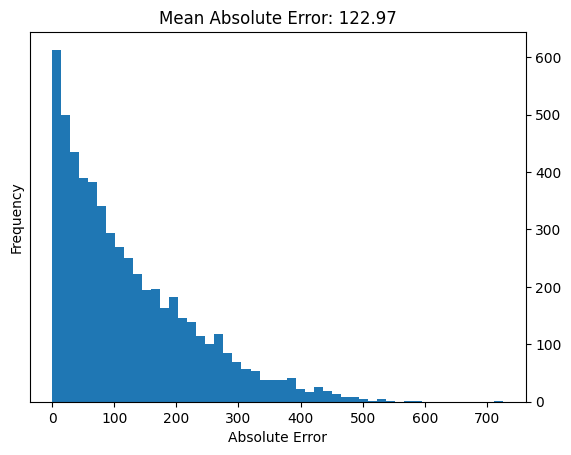

In [20]:
plot_mean_abs_error(y_test, model.predict(X_test))

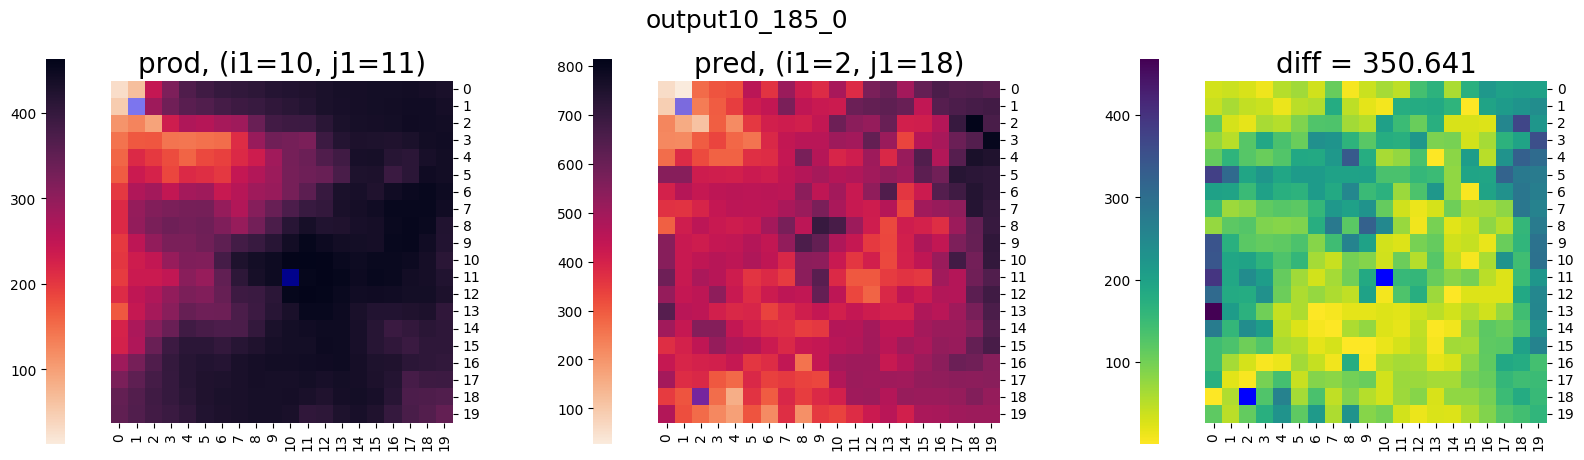

In [21]:
draw_difference(
    test_df, test_files, 
#     file="output10_185_0",
)

### 2.2. Consider i1, j1 as a regressors

In [22]:
model = CatBoostRegressor(loss_function="MAE")
model.fit(X_train, y_train)
test_df["pred"] = model.predict(test_df.drop("prod", axis=1))

0:	learn: 216.6283792	total: 3.9ms	remaining: 3.9s
1:	learn: 213.0721315	total: 7.51ms	remaining: 3.75s
2:	learn: 209.6004710	total: 10.7ms	remaining: 3.56s
3:	learn: 206.3035490	total: 13.6ms	remaining: 3.38s
4:	learn: 203.3311978	total: 16.4ms	remaining: 3.25s
5:	learn: 200.3498059	total: 19.2ms	remaining: 3.18s
6:	learn: 197.6123688	total: 22.1ms	remaining: 3.13s
7:	learn: 194.9596373	total: 25.1ms	remaining: 3.12s
8:	learn: 192.3242881	total: 27.9ms	remaining: 3.07s
9:	learn: 189.9080425	total: 30.4ms	remaining: 3.01s
10:	learn: 187.5238251	total: 33ms	remaining: 2.97s
11:	learn: 185.3554404	total: 35.6ms	remaining: 2.93s
12:	learn: 183.1138483	total: 38.4ms	remaining: 2.91s
13:	learn: 181.0025661	total: 41ms	remaining: 2.88s
14:	learn: 178.8734640	total: 43.5ms	remaining: 2.85s
15:	learn: 176.9354484	total: 45.9ms	remaining: 2.82s
16:	learn: 175.0698532	total: 48.5ms	remaining: 2.8s
17:	learn: 173.2741612	total: 50.9ms	remaining: 2.77s
18:	learn: 171.5545698	total: 53.3ms	remainin

159:	learn: 124.1097822	total: 395ms	remaining: 2.07s
160:	learn: 124.0706184	total: 398ms	remaining: 2.07s
161:	learn: 124.0279832	total: 401ms	remaining: 2.07s
162:	learn: 123.9629095	total: 403ms	remaining: 2.07s
163:	learn: 123.9107455	total: 406ms	remaining: 2.07s
164:	learn: 123.8495301	total: 408ms	remaining: 2.06s
165:	learn: 123.8099837	total: 411ms	remaining: 2.06s
166:	learn: 123.7575956	total: 413ms	remaining: 2.06s
167:	learn: 123.7440362	total: 416ms	remaining: 2.06s
168:	learn: 123.6995674	total: 419ms	remaining: 2.06s
169:	learn: 123.6533775	total: 421ms	remaining: 2.06s
170:	learn: 123.6045071	total: 436ms	remaining: 2.11s
171:	learn: 123.5518554	total: 439ms	remaining: 2.11s
172:	learn: 123.5067071	total: 443ms	remaining: 2.12s
173:	learn: 123.4684478	total: 446ms	remaining: 2.12s
174:	learn: 123.4143732	total: 449ms	remaining: 2.12s
175:	learn: 123.3813304	total: 452ms	remaining: 2.12s
176:	learn: 123.3389558	total: 455ms	remaining: 2.11s
177:	learn: 123.3094708	tota

314:	learn: 119.7429104	total: 788ms	remaining: 1.71s
315:	learn: 119.7300519	total: 791ms	remaining: 1.71s
316:	learn: 119.7106136	total: 793ms	remaining: 1.71s
317:	learn: 119.6976087	total: 796ms	remaining: 1.71s
318:	learn: 119.6803540	total: 799ms	remaining: 1.71s
319:	learn: 119.6739669	total: 802ms	remaining: 1.7s
320:	learn: 119.6587406	total: 804ms	remaining: 1.7s
321:	learn: 119.6328352	total: 807ms	remaining: 1.7s
322:	learn: 119.6173405	total: 810ms	remaining: 1.7s
323:	learn: 119.5923701	total: 813ms	remaining: 1.7s
324:	learn: 119.5734843	total: 816ms	remaining: 1.69s
325:	learn: 119.5490763	total: 819ms	remaining: 1.69s
326:	learn: 119.5373013	total: 821ms	remaining: 1.69s
327:	learn: 119.5092672	total: 824ms	remaining: 1.69s
328:	learn: 119.5030656	total: 827ms	remaining: 1.69s
329:	learn: 119.4864093	total: 830ms	remaining: 1.69s
330:	learn: 119.4665066	total: 833ms	remaining: 1.68s
331:	learn: 119.4429134	total: 836ms	remaining: 1.68s
332:	learn: 119.4221014	total: 83

480:	learn: 116.7070281	total: 1.18s	remaining: 1.27s
481:	learn: 116.6969843	total: 1.18s	remaining: 1.27s
482:	learn: 116.6877038	total: 1.18s	remaining: 1.27s
483:	learn: 116.6806764	total: 1.19s	remaining: 1.26s
484:	learn: 116.6654327	total: 1.19s	remaining: 1.26s
485:	learn: 116.6566479	total: 1.19s	remaining: 1.26s
486:	learn: 116.6443793	total: 1.19s	remaining: 1.26s
487:	learn: 116.6243112	total: 1.2s	remaining: 1.26s
488:	learn: 116.5940452	total: 1.2s	remaining: 1.25s
489:	learn: 116.5749185	total: 1.2s	remaining: 1.25s
490:	learn: 116.5600049	total: 1.21s	remaining: 1.25s
491:	learn: 116.5398038	total: 1.21s	remaining: 1.25s
492:	learn: 116.5123175	total: 1.21s	remaining: 1.25s
493:	learn: 116.5047028	total: 1.21s	remaining: 1.24s
494:	learn: 116.4934646	total: 1.22s	remaining: 1.24s
495:	learn: 116.4731960	total: 1.22s	remaining: 1.24s
496:	learn: 116.4652630	total: 1.22s	remaining: 1.24s
497:	learn: 116.4556596	total: 1.23s	remaining: 1.23s
498:	learn: 116.4477504	total: 

639:	learn: 114.7583341	total: 1.57s	remaining: 883ms
640:	learn: 114.7317865	total: 1.57s	remaining: 881ms
641:	learn: 114.7239489	total: 1.57s	remaining: 878ms
642:	learn: 114.7170534	total: 1.58s	remaining: 876ms
643:	learn: 114.7044946	total: 1.58s	remaining: 874ms
644:	learn: 114.7004272	total: 1.58s	remaining: 871ms
645:	learn: 114.6883325	total: 1.58s	remaining: 868ms
646:	learn: 114.6701791	total: 1.59s	remaining: 866ms
647:	learn: 114.6556542	total: 1.59s	remaining: 864ms
648:	learn: 114.6504044	total: 1.59s	remaining: 862ms
649:	learn: 114.6381523	total: 1.59s	remaining: 859ms
650:	learn: 114.6211266	total: 1.6s	remaining: 857ms
651:	learn: 114.6185542	total: 1.6s	remaining: 855ms
652:	learn: 114.6145291	total: 1.6s	remaining: 852ms
653:	learn: 114.6120806	total: 1.61s	remaining: 850ms
654:	learn: 114.5967038	total: 1.61s	remaining: 848ms
655:	learn: 114.5834284	total: 1.61s	remaining: 846ms
656:	learn: 114.5669609	total: 1.61s	remaining: 843ms
657:	learn: 114.5573727	total: 

799:	learn: 113.2923304	total: 1.96s	remaining: 491ms
800:	learn: 113.2785599	total: 1.97s	remaining: 488ms
801:	learn: 113.2752935	total: 1.97s	remaining: 486ms
802:	learn: 113.2722300	total: 1.97s	remaining: 483ms
803:	learn: 113.2637481	total: 1.97s	remaining: 481ms
804:	learn: 113.2563104	total: 1.98s	remaining: 478ms
805:	learn: 113.2417210	total: 1.98s	remaining: 476ms
806:	learn: 113.2297519	total: 1.98s	remaining: 474ms
807:	learn: 113.2179489	total: 1.98s	remaining: 471ms
808:	learn: 113.2099698	total: 1.99s	remaining: 469ms
809:	learn: 113.2044391	total: 1.99s	remaining: 466ms
810:	learn: 113.1866570	total: 1.99s	remaining: 464ms
811:	learn: 113.1830578	total: 1.99s	remaining: 461ms
812:	learn: 113.1766932	total: 2s	remaining: 459ms
813:	learn: 113.1655379	total: 2s	remaining: 457ms
814:	learn: 113.1523906	total: 2s	remaining: 454ms
815:	learn: 113.1491667	total: 2s	remaining: 452ms
816:	learn: 113.1475257	total: 2.01s	remaining: 449ms
817:	learn: 113.1443390	total: 2.01s	rem

961:	learn: 112.0627677	total: 2.35s	remaining: 93ms
962:	learn: 112.0616380	total: 2.36s	remaining: 90.6ms
963:	learn: 112.0592760	total: 2.36s	remaining: 88.1ms
964:	learn: 112.0536332	total: 2.36s	remaining: 85.6ms
965:	learn: 112.0501979	total: 2.36s	remaining: 83.2ms
966:	learn: 112.0421282	total: 2.37s	remaining: 80.7ms
967:	learn: 112.0336197	total: 2.37s	remaining: 78.3ms
968:	learn: 112.0260311	total: 2.37s	remaining: 75.8ms
969:	learn: 112.0246259	total: 2.37s	remaining: 73.4ms
970:	learn: 112.0214308	total: 2.38s	remaining: 71ms
971:	learn: 112.0107971	total: 2.38s	remaining: 68.5ms
972:	learn: 112.0040271	total: 2.38s	remaining: 66.1ms
973:	learn: 112.0012092	total: 2.38s	remaining: 63.6ms
974:	learn: 111.9916347	total: 2.38s	remaining: 61.2ms
975:	learn: 111.9781694	total: 2.39s	remaining: 58.7ms
976:	learn: 111.9767803	total: 2.39s	remaining: 56.2ms
977:	learn: 111.9694804	total: 2.39s	remaining: 53.8ms
978:	learn: 111.9617175	total: 2.39s	remaining: 51.3ms
979:	learn: 11

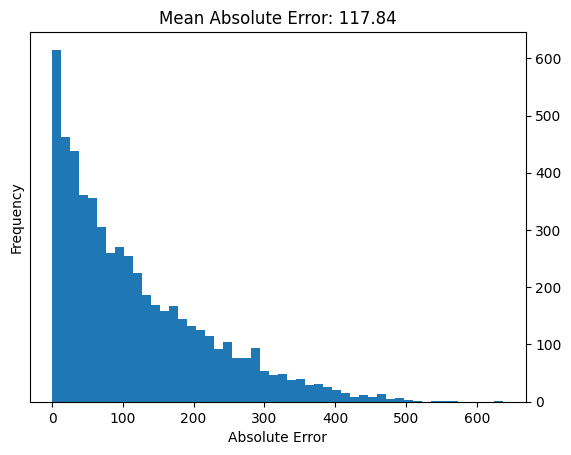

In [23]:
plot_mean_abs_error(y_test, model.predict(X_test))

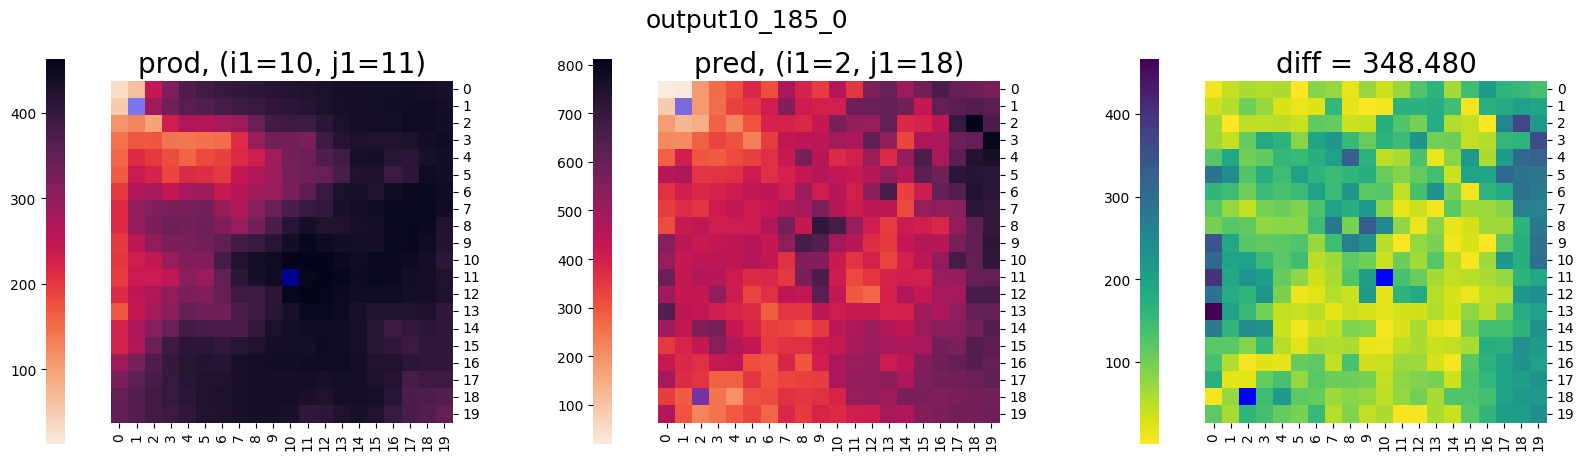

In [24]:
draw_difference(
    test_df, test_files, 
    file="output10_185_0",
)

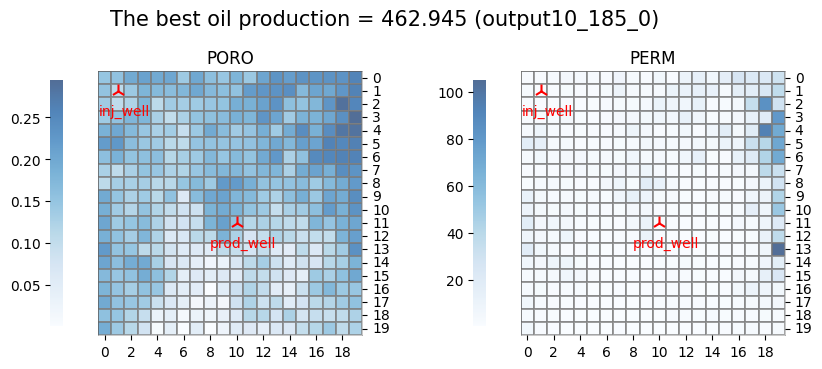

In [25]:
draw_map(data_max_prod, filename="output10_185_0")

## 3. Deep Learning Model: The Neural Network

In [200]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [201]:
data_max_prod = data_max_prod.set_index("filename")
data_max_prod.head()

KeyError: "None of ['filename'] are in the columns"

In [203]:
test_files = list(data_max_prod.index.unique()[:1000])
val_files = list(data_max_prod.index.unique()[1000:2000])
train_files = list(data_max_prod.index.unique()[2000:])

test_df = data_max_prod.query("filename in @test_files")
val_df = data_max_prod.query("filename in @val_files")
train_df = data_max_prod.query("filename in @train_files")

In [275]:
BATCH_SIZE = 32
MAP_SIZE = 20 * 20
EPOCHS = 200
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [276]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        self.input_layer = nn.Linear(2 * MAP_SIZE, 256)
        self.hidden_layer1 = nn.Linear(256, 128)
        self.hidden_layer2 = nn.Linear(128, 64)
        self.hidden_layer3 = nn.Linear(64, 32)
        self.hidden_layer4 = nn.Linear(32, 8)
        
        self.hidden_layer_ = nn.Linear(256,8)
        
        # Define the output layer
        self.output_layer = nn.Linear(8, 2)
        
    def forward(self, x: torch.Tensor):
        # [batch, 2 * 400]
        x = x.view(-1, 2 * 400)
        
        x = self.input_layer(x)
        x = nn.functional.relu(x)
        
        x = self.hidden_layer1(x)
        x = nn.functional.relu(x)
    
        x = self.hidden_layer2(x)
        x = nn.functional.relu(x)
        
        x = self.hidden_layer3(x)
        x = nn.functional.relu(x)
    
        x = self.hidden_layer4(x)
        x = nn.functional.relu(x)
        
#         x = self.hidden_layer_(x)
#         x = nn.functional.relu(x)
        
        x = self.output_layer(x)
        
        # [batch, 2]
        return x

In [277]:
net = MyNet()
x = torch.randn(BATCH_SIZE, 2, MAP_SIZE)
output = net(x)

assert output.shape == torch.Size([BATCH_SIZE, 2])

In [244]:
train_inputs, val_inputs, test_inputs = [], [], []

for filename in tqdm(data_max_prod.index.unique()):
    sub_df = df_geo.query("filename == @filename")
    if filename in test_files:
        test_inputs.append(
            torch.Tensor(np.array([sub_df["poro"].values, sub_df["perm"].values]))
        )
    elif filename in val_files:
        val_inputs.append(
            torch.Tensor(np.array([sub_df["poro"].values, sub_df["perm"].values]))
        )
    else:
        train_inputs.append(
            torch.Tensor(np.array([sub_df["poro"].values, sub_df["perm"].values]))
        )

100%|███████████████████████████████████████| 7482/7482 [07:04<00:00, 17.64it/s]


In [245]:
print("Stacking")        
train_inputs = torch.stack(train_inputs, dim=0)
val_inputs = torch.stack(val_inputs, dim=0)
test_inputs = torch.stack(test_inputs, dim=0)

assert train_inputs.shape[1] == 2
assert train_inputs.shape[2] == MAP_SIZE

Stacking


In [246]:
print("Filtering")        
train_labels = torch.Tensor(
    best_wells_df.query("filename in @train_files")[["i1", "j1"]].values
)
val_labels = torch.Tensor(
    best_wells_df.query("filename in @val_files")[["i1", "j1"]].values
)

test_labels = torch.Tensor(
    best_wells_df.query("filename in @test_files")[["i1", "j1"]].values
)

assert train_labels.shape[0] == train_inputs.shape[0]
assert train_labels.shape[1] == 2

Filtering


In [278]:
train_data = TensorDataset(
    train_inputs, train_labels
)
val_data = TensorDataset(
    val_inputs, val_labels
)
test_data = TensorDataset(
    test_inputs, test_labels
)

train_loader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
)
val_loader = DataLoader(
    val_data, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
)
test_loader = DataLoader(
    test_data, 
    batch_size=1, 
    shuffle=False,
)

assert len(train_data) + len(val_data) + len(test_data) == len(best_wells_df["filename"])

In [279]:
def train(
    model: nn.Module, 
    train_loader: DataLoader, 
    val_loader: DataLoader, 
    opt: optim, 
    epochs: int = 10
) -> Tuple[List, List]:
    train_losses, val_losses, val_full_acc, train_full_acc = [], [], [], []
    loss_fn = nn.L1Loss()
    best_model_weights = deepcopy(model.state_dict())
    best_val_loss = float("inf")
    best_epoch = float("inf")
    
    for epoch in trange(epochs):

        # TRAIN
        model.train()
        current_train_loss = 0

        for inputs, labels in train_loader:
            X_batch = inputs.to(DEVICE)
            Y_batch = labels.to(DEVICE)
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()

            current_train_loss += loss.item() * X_batch.size(0)

        opt.step()

        train_loss = current_train_loss / len(train_data)
        train_losses.append(train_loss)
#         print('train loss =', train_loss)

        # VALIDATION
        if val_loader is not None:
            model.eval()
            current_val_loss = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    X_batch = inputs.to(DEVICE)
                    Y_batch = labels.to(DEVICE)

                    Y_pred = model(X_batch)
                    loss = loss_fn(Y_pred, Y_batch)
                    current_val_loss += loss.item() * X_batch.size(0)

            val_loss = current_val_loss / len(val_data)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_weights = deepcopy(model.state_dict())
                best_epoch = epoch
#                 print('Save new model!')

            val_losses.append(val_loss)
#             print('val loss =', val_loss)
    
        clear_output(wait=True)

    return train_losses, val_losses, best_model_weights, best_epoch

In [280]:
model = MyNet().to(DEVICE);

In [281]:
opt = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
(
    train_losses, 
    val_losses, 
    best_model_weights,
    best_epoch
) = train(
    model, 
    train_loader, 
    val_loader, 
    opt, 
    epochs=EPOCHS,
)

model.load_state_dict(best_model_weights)

100%|█████████████████████████████████████████| 600/600 [07:15<00:00,  1.38it/s]


<All keys matched successfully>

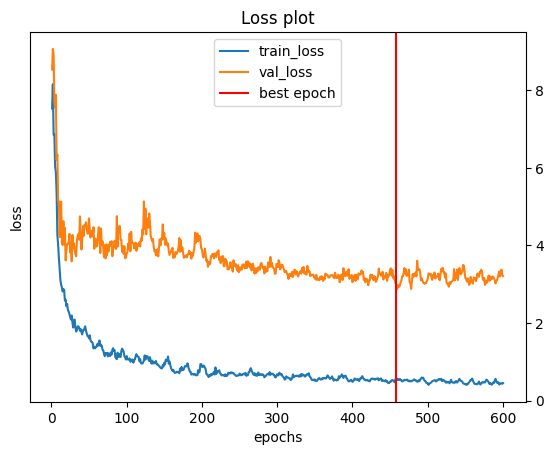

In [287]:
def draw_loss_plot() -> None:
    plt.title('Loss plot')
    plt.plot(list(range(1,EPOCHS+1)), train_losses, label="train_loss")
    plt.plot(list(range(1,EPOCHS+1)), val_losses, label="val_loss")

    plt.axvline(x=best_epoch, c='r', label="best epoch")

    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    
draw_loss_plot()

In [288]:
def do_test_on_test() -> Tuple[Dict, List]:
    test_results = {}
    distance = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            filename = test_files[i]
            inputs, labels = data
            X_batch = inputs.to(DEVICE)
            Y_batch = labels.to(DEVICE)

            poro, perm = X_batch[0]
            outputs = model(X_batch).to(torch.int8)
            Y_batch = Y_batch.to(torch.int8)

            i1_real, j1_real = [i.item() for i in Y_batch[0]]
            i1_pred, j1_pred = [max(min(i.item(), 19), 0) for i in outputs[0]]

            sub_geo = pd.DataFrame({
                "filename": filename,
                "poro": poro,
                "perm": perm,
            })
        
            wells_df = pd.DataFrame({
                "well_type": ['inj_well', 'prod_well_real', 'prod_well_pred'],
                "x_coord": [1, i1_real, i1_pred],
                "y_coord": [1, j1_real, j1_pred],
            })
            
            distance.append(
                np.sqrt(
                    ((i1_real - i1_pred) ** 2 + (j1_real - j1_pred) ** 2)
                )
            )

            test_results[filename] = [sub_geo, wells_df]
        
    return test_results, np.array(distance)

In [289]:
def do_test_on_train() -> Tuple[Dict, List]:
    train_loader_2 = DataLoader(
        train_data, 
        batch_size=1, 
        shuffle=False,
    )

    train_results = {}
    distance = []
    with torch.no_grad():
        for i, data in enumerate(train_loader_2):
            filename = train_files[i]
            inputs, labels = data
            X_batch = inputs.to(DEVICE)
            Y_batch = labels.to(DEVICE)

            poro, perm = X_batch[0]
            outputs = model(X_batch).to(torch.int8)
            Y_batch = Y_batch.to(torch.int8)

            i1_real, j1_real = [i.item() for i in Y_batch[0]]
            i1_pred, j1_pred = [max(min(i.item(), 19), 0) for i in outputs[0]]

            sub_geo = pd.DataFrame({
                "filename": filename,
                "poro": poro,
                "perm": perm,
            })

            wells_df = pd.DataFrame({
                "well_type": ['inj_well', 'prod_well_real', 'prod_well_pred'],
                "x_coord": [1, i1_real, i1_pred],
                "y_coord": [1, j1_real, j1_pred],
            })

            distance.append(
                np.sqrt(
                    ((i1_real - i1_pred) ** 2 + (j1_real - j1_pred) ** 2)
                )
            )

            train_results[filename] = [sub_geo, wells_df]
    
    return train_results, np.array(distance)

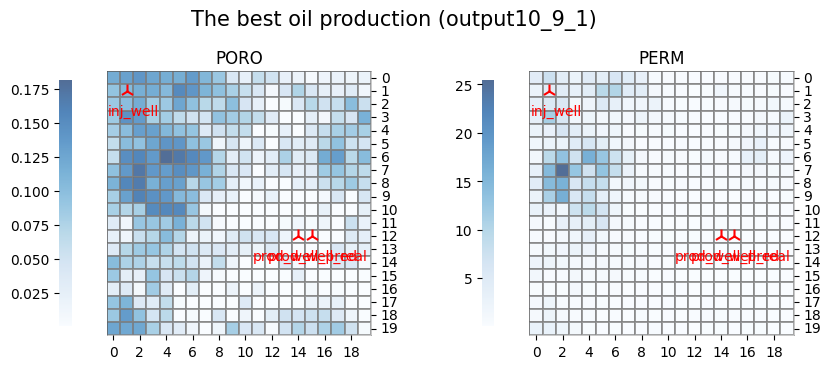

In [290]:
test_results, test_distance = do_test_on_test()
_draw_map_with_wells(*test_results[random.choice(test_files)])

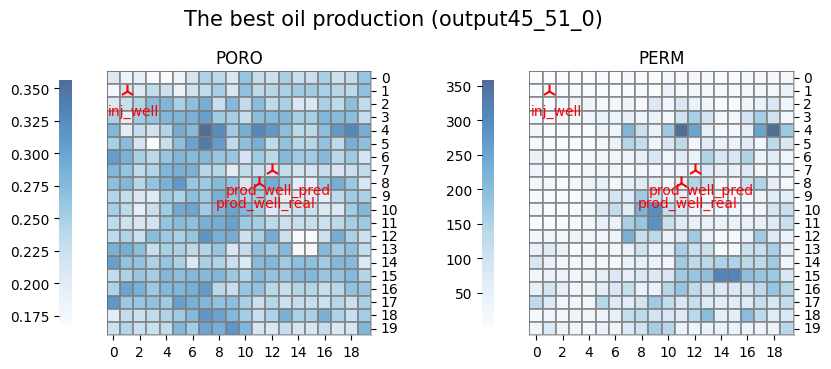

In [291]:
train_results, train_distance = do_test_on_train()
_draw_map_with_wells(*train_results[random.choice(train_files)])

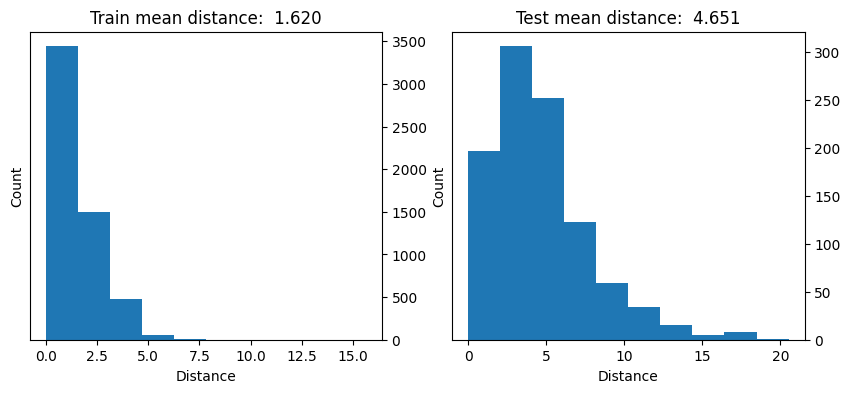

In [292]:
fig, axs = plt.subplots(1, 2, figsize=[10, 4])
mean_test = test_distance[~np.isnan(test_distance)].mean()
mean_train = train_distance[~np.isnan(train_distance)].mean()

axs[0].set_title(f"Train mean distance: {mean_train : .3f}")
axs[0].hist(train_distance[~np.isnan(train_distance)])

axs[1].set_title(f"Test mean distance: {mean_test : .3f}")
axs[1].hist(test_distance[~np.isnan(test_distance)])


for i in range(2):
    axs[i].set_xlabel("Distance")
    axs[i].set_ylabel("Count")